## QuasarNET Performance test
#### Plot to show performance of QuasarNET models
xxx

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
import astropy
import copy
import numpy as np
from matplotlib import pyplot as plt

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,8)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [3]:
common_specids = False

## RR parameters
include_fits_rr = True

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [34]:
data = {}

"""## Load the RR andmask data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_andmask_coadd.fits'
data['RR andmask coadd'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp andmask randexp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_andmask_randexp.fits'
data['RRngp andmask randexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp andmask bestexp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_andmask_bestexp.fits'
data['RRngp andmask bestexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load BOSS pipeline data.
f_pipe = variables.OUTDIR+'/results/dr12pipe_results/dr12pipe_sdr12q.fits'
data['PIPE'] = utils.load_rr_data(f_pipe,include_fits=include_fits_rr)"""

## Load the QN data.
f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/coadd/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_coadd_0_0-test_coadd.fits'
data['QN coadd'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN randexp data.
#singexp_mode = 'randexp'
#f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/{m}/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_{m}_0_0-test_{m}.fits'.format(m=singexp_mode)
#data['QN randexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN bestexp data.
#singexp_mode = 'bestexp'
#f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/{m}/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_{m}_0_0-test_{m}.fits'.format(m=singexp_mode)
#data['QN bestexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

"""## Load the SQ data.
f_sq = variables.OUTDIR+'/results/sq_results/sq_sdr12q.fits'
data['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)"""

"## Load the SQ data.\nf_sq = variables.OUTDIR+'/results/sq_results/sq_sdr12q.fits'\ndata['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)"

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [35]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq,
                                  include_fits_rr=include_fits_rr,
                                  common_specids=common_specids,
                                  )

In [36]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
print('INFO: removed {}/{} spectra, {} left'.format((~w).sum(),len(w),len(data_table)))

INFO: removed 20249/526466 spectra, 506217 left


In [37]:
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN coadd,CLASS_QN coadd,ISQSO_QN coadd,C_QN coadd [6],Z_LINES_QN coadd [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,float64,float64
7166566020362,20589337,2,1.616,QSO,True,1.615,NONQSO,False,0.000 .. 0.000,2.137 .. 0.466
7169566280047,20935261,2,0.000,STAR,False,3.517,NONQSO,False,0.000 .. 0.000,3.517 .. 0.349
7169566280046,20935742,2,0.000,STAR,False,0.459,NONQSO,False,0.000 .. 0.000,4.656 .. 0.341
7169566280052,20936956,2,0.000,STAR,False,0.974,NONQSO,False,0.000 .. 0.000,2.577 .. 0.353
7169566280088,20938894,2,0.000,STAR,False,0.970,NONQSO,False,0.000 .. 0.000,2.938 .. -0.089


In [ ]:
dv_max = 6000.
bins = np.linspace(0.,1.,101)

dv_lines = 300000 * (data_table['Z_LINES_QN coadd'] - data_table['Z_VI'][:,None]) / (1 + data_table['Z_VI'][:,None])
correct = dv_lines<dv_max

In [ ]:
fig, axs = plt.subplots(1,1,squeeze=False,figsize=figsize)
hist_count, bins = np.histogram(data_table['C_QN coadd'].flatten(),bins=bins)
hist_correct, bins = np.histogram(data_table['C_QN coadd'].flatten(),bins=bins,weights=correct.flatten().astype(int))
axs[0,0].plot((bins[:-1]+bins[1:])/2,hist_correct/hist_count)

axs[0,0].set_xlim(0.,1.)
axs[0,0].set_ylim(0.,1.01)
axs[0,0].axhline(y=1.,c='lightgrey',ls='--',zorder=-1)

In [ ]:
fig, axs = plt.subplots(1,1,squeeze=False,figsize=figsize)
lines = ['LYA', 'CIV(1548)', 'CIII(1909)', 'MgII(2796)', 'Hbeta', 'Halpha']
for i in range(6):
    hist_count_line, bins = np.histogram(data_table['C_QN coadd'][:,i],bins=bins)
    hist_correct_line, bins = np.histogram(data_table['C_QN coadd'][:,i],bins=bins,weights=correct[:,i].astype(int))
    plt.plot((bins[:-1]+bins[1:])/2,hist_correct_line/hist_count_line,label=lines[i])

axs[0,0].set_xlim(0.,1.)
axs[0,0].set_ylim(0.,1.01)
axs[0,0].axhline(y=1.,c='lightgrey',ls='--',zorder=-1)
plt.legend()

In [ ]:
fig, axs = plt.subplots(1,1,squeeze=False,figsize=figsize)
sigma_dv = []
for i,c_lo in enumerate(bins[:-1]):
    c_hi = bins[i+1]
    inbin = (data_table['C_QN coadd']>c_lo) & (data_table['C_QN coadd']<=c_hi)
    sigma_dv += [np.std(dv_lines[inbin].flatten())]

axs[0,0].plot((bins[:-1]+bins[1:])/2,sigma_dv)

## Look at success of identifying a certain line as a function of redshift

In [62]:
c_th = 0.6
i_line = 0
l_line = 1215.67
z_min = 0.
z_max = 5.
n_z = 5000

wqso = data_table['ISQSO_VI']
qn_lya = (data_table['C_QN coadd'][:,i_line]>c_th)
z_bins = np.linspace(z_min,z_max,n_z+1)



In [63]:
hist_qn = np.histogram(data_table['Z_LINES_QN coadd'][:,i_line], bins=z_bins, weights=(qn_lya).astype(int))
hist_qn_correct = np.histogram(data_table['Z_LINES_QN coadd'][:,i_line], bins=z_bins, weights=(qn_lya&wqso).astype(int))

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


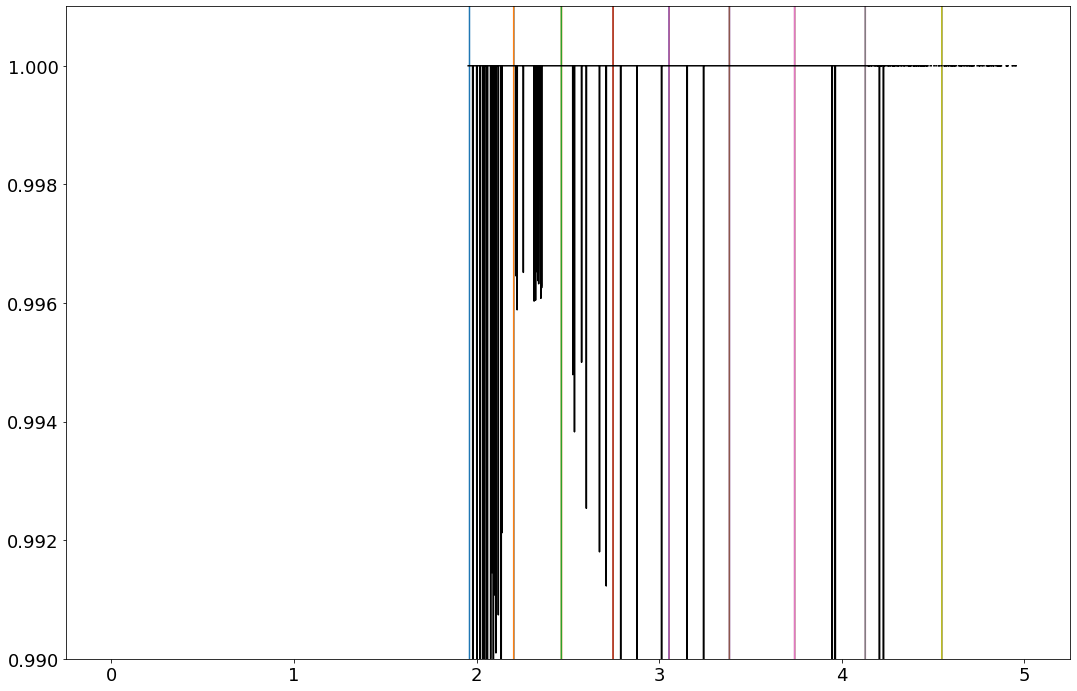

In [65]:
fig, axs = plt.subplots(1,1,figsize=(18,12),squeeze=False)
axs[0,0].plot(z_bins[:-1],hist_qn_correct[0]/hist_qn[0],c='k')
axs[0,0].set_ylim(0.99,1.001)

from quasarnet.io import box_offset
box, offset, weights = box_offset(z_bins)
for j in range(box.shape[1]):
    plt.plot(z_bins,box[:,j]*10,zorder=-1)

In [57]:
box.shape

(1001, 13)

### Compare the performance of the different model/data combos.
xxx

In [29]:
ls = {'QN_norm': '-',
      'QN_norm_lowloss': '--',
      
      'QN_amsgrad': ':',
      
      'QN_dllfix': '-.',
      'QN_dllfixbest': (0, (3, 5, 1, 5, 1, 5)),
     }

In [30]:
## General parameters
dv_max = 6000. #km/s

## QN parameters
c_th_min = 0.0
c_th_max = 1.0
n_int = 101
c_th_values = np.linspace(c_th_min,c_th_max,n_int)
n_detect = 1

In [31]:
## Define strategies.
strategies = {}

for s in data.keys():
        
    name = (s.split('_')[-1])

    # QN definitions.
    n_detect = 1
    strat = strategy.Strategy('qn',cf_kwargs={'qn_name':s})
    preds = [strat.predict(data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
    strategies[s] = {'predictions': preds,
                     'n': name, 
                     'ls': ls[s]}

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:290: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]


Strategy QN_norm:
Crossover occurs at:
cth: [0.03 0.04 0.05 0.06]
pur: [0.9884 0.9892 0.9897 0.9902]
com: [0.9901 0.9898 0.9896 0.9894]
QN_norm has median velocity error -333.533 and standard deviation 1351.263

Strategy QN_norm_lowloss:
Crossover occurs at:
cth: [0.13 0.14 0.15 0.16]
pur: [0.9936 0.9938 0.9939 0.9941]
com: [0.994  0.9939 0.9939 0.9938]
QN_norm_lowloss has median velocity error 0.218 and standard deviation 768.234

Strategy QN_amsgrad:
Crossover occurs at:
cth: [0.13 0.14 0.15 0.16]
pur: [0.9933 0.9935 0.9936 0.9938]
com: [0.9937 0.9937 0.9936 0.9935]
QN_amsgrad has median velocity error -39.897 and standard deviation 848.817

Strategy QN_dllfix:
Crossover occurs at:
cth: [0.07 0.08 0.09 0.1 ]
pur: [0.9935 0.9938 0.9941 0.9943]
com: [0.9942 0.9941 0.994  0.9938]
QN_dllfix has median velocity error 47.831 and standard deviation 799.698

Strategy QN_dllfixbest:
Crossover occurs at:
cth: [0.07 0.08 0.09 0.1 ]
pur: [0.9935 0.9938 0.9941 0.9943]
com: [0.9942 0.9941 0.994  0

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:334: RuntimeWarning: invalid value encountered in greater
  ind = np.where(mean_pur>mean_com)[0][0]


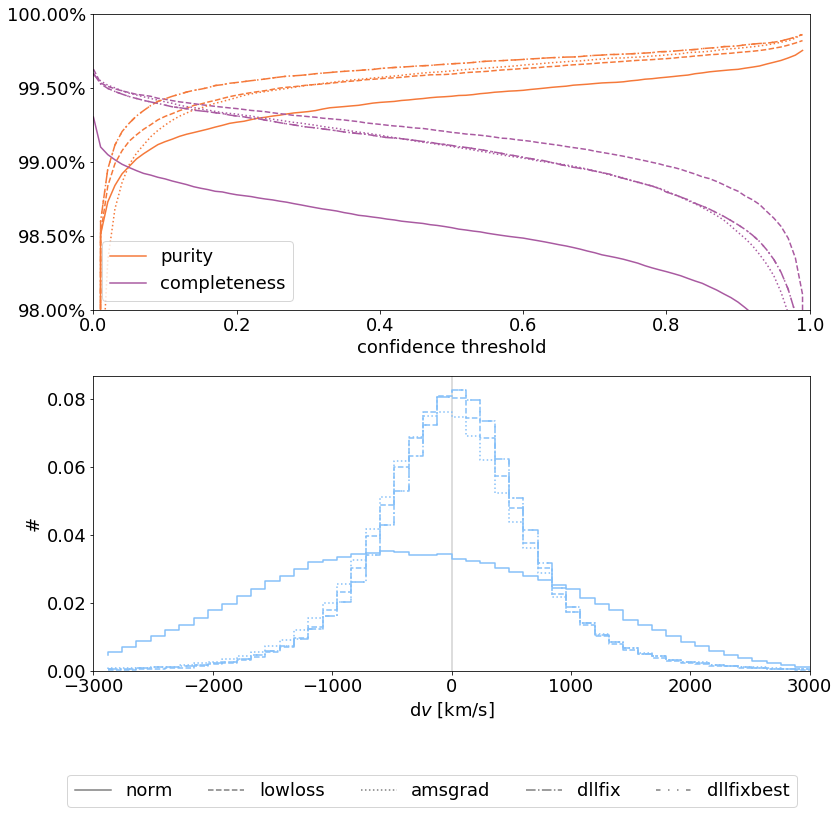

In [32]:
filename = '../plots/qn_performance_test_new.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=2,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values)
plt.show()